# c) Fitting a logistic regression model for the probability of diverted US flights using as many features as possible as such departure date,  scheduled departure and arrival times, coordinates and distance between departure and planned arrival airports, and the Uniquecarriers. Visualize the coefficients across years as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score
import sklearn.metrics as metrics

import os

## General codes and explanation using 1999 as the template

#### Put this file into the folder containing relevant year csvs and other csvs to read the csvs 

In [3]:
df = pd.read_csv("1999.csv")
print(df.columns)

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')


In [4]:
# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 
airports_df.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [5]:
# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")
carriers_df.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


### choosing the different features :  The scheduled departure and arrival times, the coordinates and distance between departure and planned arrival airports

### We merge the airports_df and carriers_df into the year df as a single dataframe for further manipulation. 

#### for df.merge(airports_df), we merge df with airports_df based on the origin column and the iata column. We then perform a left join, retaining all rows from the year df dataframe and the matching rows from airports_df are added. The suffixes=('_Departure', '_Origin') parameter adds suffixes to the overlapping column names to distinguish them after merging.

#### The 2nd .merge(airports_df), we further merge the result of the previous merge operation with airports_df based on the Dest column of the result dataframe and the iata column of airports_df. We again performs a left join and adds suffixes to distinguish the overlapping column names.

#### The last .merge(carriers_df), we lastly merge the result dataframe with carriers_df based on the UniqueCarrier column of the result dataframe and the Code column of carriers_df via a left join.

#### After fully merging and creating the merged_df, we filter out cancelled flights to 1. remove NaN values and 2. remove flights that didnt finish their expected trip

In [8]:
# Merge airports_df and carriers_df into df
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filter out canceled flights i.e Cancelled == 1 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]



print(merged_df.head())

   Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  1999      1          27          3   1906.0        1908   2024.0   
1  1999      1          28          4   2016.0        1908   2126.0   
2  1999      1          29          5   1907.0        1908   2000.0   
3  1999      1          31          7   1932.0        1908   2031.0   
4  1999      1           1          5   1601.0        1535   1707.0   

   CRSArrTime UniqueCarrier  FlightNum  ... long_Arrival  iata_Destination  \
0        2005            US       1244  ...   -77.319667               PHL   
1        2005            US       1244  ...   -77.319667               PHL   
2        2005            US       1244  ...   -77.319667               PHL   
3        2005            US       1244  ...   -77.319667               PHL   
4        1645            US        297  ...   -77.672384               PHL   

   airport_Destination  city_Destination  state_Destination  \
0    Philadelphia Intl      Philadelphia 

#### The coordinates feature is not a column in any of the dataframes, hence we use the lat_Dest, lat_Arr, long_Dest and long_Arr in the merged_df columns to find the coordinates

#### To calculate / find the coordinates , we calculate the midpoint of both lat and long and create 2 new columns called latitude and longitude that conists of the Midpoint_Latitude and Midpoint_Longitude and these 2 newly formed columns will be the placeholder for coordinates

#### The coordinates feature will be represented by these 2 sub columns to prevent data type errors during the machine learning process later

In [9]:
# Calculate the midpoint coordinates
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature would conisit of latitude and longitude separately to prevent value error in following codes 

merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


print(merged_df.head())


   Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  1999      1          27          3   1906.0        1908   2024.0   
1  1999      1          28          4   2016.0        1908   2126.0   
2  1999      1          29          5   1907.0        1908   2000.0   
3  1999      1          31          7   1932.0        1908   2031.0   
4  1999      1           1          5   1601.0        1535   1707.0   

   CRSArrTime UniqueCarrier  FlightNum  ... state_Destination  \
0        2005            US       1244  ...                PA   
1        2005            US       1244  ...                PA   
2        2005            US       1244  ...                PA   
3        2005            US       1244  ...                PA   
4        1645            US        297  ...                PA   

   country_Destination  lat_Destination  long_Destination  Code  \
0                  USA        39.871953        -75.241141    US   
1                  USA        39.871953        -

### We separated the features to categorial and numerical and the following codes will be looking into specifically numerical features 

In [10]:
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']] # CRSDepTime , CRSArrTime and Distance can be found in the year df 
x = features
# classifying Diverted column to show that Diverted == 0 means not diverted and == 1 means diverted 
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0) # We do not filter to remove diverted flight as in this case, we want both diverted and non-diverted flights to find probability 

#### Pre processing the data ( numerical features ) before feeding it into the predictve / machine learning model

In [11]:

numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Create transformers for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),  # Missing values in the numerical features are filled using the SimpleImputer
    ('scaler', StandardScaler())]) # The numerical features are then standardised using the StandardScaler 


data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)]) # ColumnTransformer is used to apply these transformations to the numerical features. This pipeline ensures that the numerical features are properly pre processed and ready to use in machine learning models.
 

#### Splits the dataset into training and testing sets using the train_test_split function from scikit-learn ( that was imported at the most front ) 

#### test_size=0.5 specifies that 50% of the data will be allocated for testing.

#### We set a random_state for every training set for consistency purposes as random_state in short is a type of random number generator

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2) 

model.fit(x_train, y_train)

In [13]:
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train);

### Plotting the logistic regression model for numerical features 

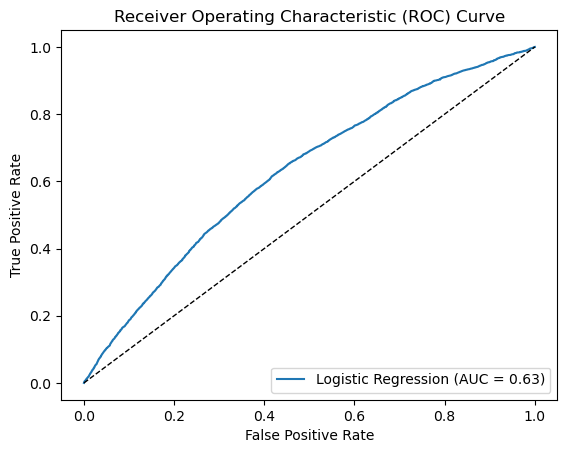

In [14]:
# Calculation
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1] # Calculates the predicted probabilities of x_test
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # Computes the False Positive Rate (FPR), True Positive Rate (TPR), and the corresponding thresholds for different probability cutoffs
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plotting 
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc) # Plots the ROC curve using the FPR and TPR values and also displays the AUC value in the legend.
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--') # AUC value
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### AUC = 0.63 shows that the predicitve model is better than random guessing, meaning it is relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally not that curved but almost a straight diagonal line, indicating that the predicitive model is ok at distinguishing between positive and negative classes and there's still room for improvement in the model

## Visualising the coefficients of the numerical features in 1999

In [16]:
# Fit the grid search to find the best logistic regression model
grid_lr.fit(x_train, y_train)

# Get the best logistic regression model from the grid search result
best_lr_model = grid_lr.best_estimator_['pipe_lr']

# Retrieve the coefficients from the logistic regression model for each feature added in the model
coefficients = best_lr_model.coef_[0]

# Retrieve the numerical feature names
numerical_feature_names = numerical_features

# Mapping each feature to its corresponding coefficient
coefficients_map = dict(zip(numerical_feature_names, coefficients))

# Print or display the results
print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


Coefficients for numerical features:
CRSDepTime: -0.05592902006292343
CRSArrTime: 0.14144969210604
Distance: 0.34419759344562045
latitude: 0.16067234577744957
longitude: 0.1944398735498242


#### Plotting the coefficients using markers 

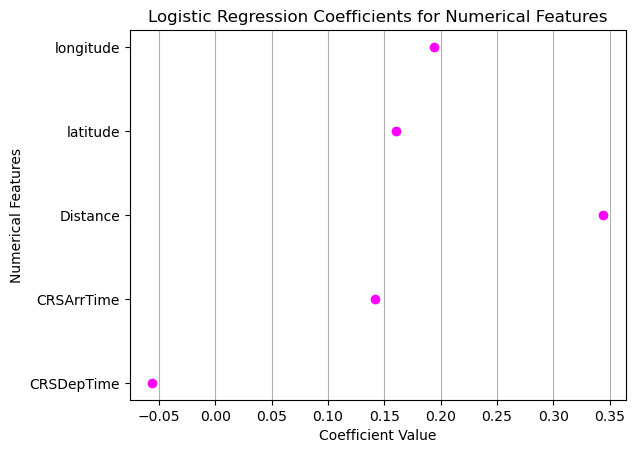

In [17]:
# Plot the logistic regression coefficients as markers

plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features')
plt.grid(axis='x')
plt.show()

#### From the diagram, the numerical features generally have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### However, we can see that CRSDepTime is the only one with a negative coefficient, meaning it has an inverse relationship where an increase in CRSDepTime causes a decrease in the likelihood of the CRSDepTime feature to be in the positive class. 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class

### Fitting UniqueCarriers into their own logistic regression model and visualising their coefficients. It's steps is the same as the numerical features but making some changes in code naming to specify this portion is for categorical

In [72]:
# Filter out canceled flights i.e Cancelled == 1 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

feature = merged_df[['UniqueCarrier']]

X = feature

# classifying Diverted column to show that Diverted == 0 means not diverted and == 1 means diverted 
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)

In [84]:
categorical_feature = ['UniqueCarrier']


# Create transformers for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])


data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

In [86]:
param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)


GridSearchCV(estimator=Pipeline(steps=[('data_transformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('scaler',
                                                                                          OneHotEncoder())]),
                                                                         ['UniqueCarrier'])])),
                                       ('pipe_lr', LogisticRegression())]),
             param_grid={'data_transformer__categorical__imputer__strategy': ['most_frequent']})

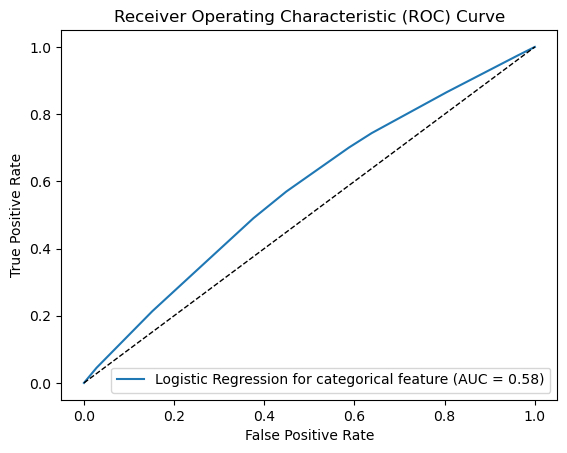

In [87]:
Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### AUC = 0.58 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself its generally almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC is steeper / less curved, hence categorical ROC has more limitations in distinguishing between positive and negative classes. Thus, categorical feature may be less important in classification

## Visualising the coefficients of the numerical features in 1999

In [102]:
# Retrieve the categories used for one-hot encoding from the categorical transformer
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

# Retrieve the coefficients from the logistic regression model
coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

# Mapping each category to its corresponding coefficient
coefficients_map = dict(zip(categories, coefficients))

# Print or display the dictionary
print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.32321264287170015
UniqueCarrier_AS: 0.33363522961682346
UniqueCarrier_CO: 0.056461511797809935
UniqueCarrier_DL: -0.229655890552981
UniqueCarrier_HP: -0.4266675730515202
UniqueCarrier_NW: 0.3130992875815403
UniqueCarrier_TW: -0.17138063308153031
UniqueCarrier_UA: -0.10746604405948554
UniqueCarrier_US: 0.20440059158761195
UniqueCarrier_WN: -0.3035659127709484


#### Plotting the coefficients using markers 

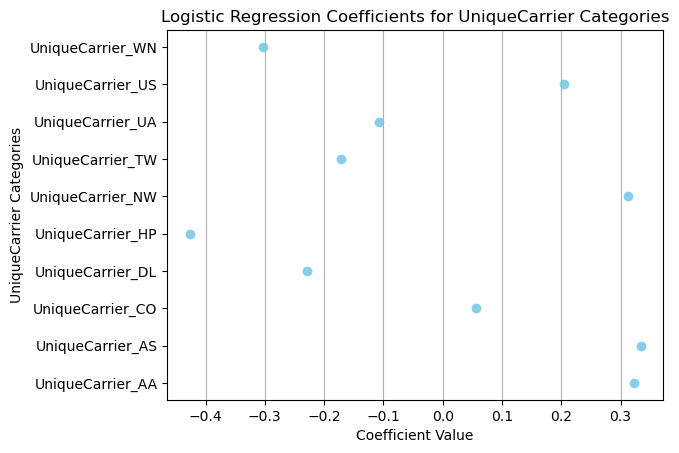

In [103]:
# Plot the logistic regression coefficients as markers

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories')
plt.grid(axis='x')
plt.show()

#### From the diagram,  half of the categorical feature have an inverse relationship with the predicting model where as when the values in the features increase, it is less likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_HP has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_AS has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has more negative coefficients, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

## Repeating these codes for the next 9 years. 

### 2000

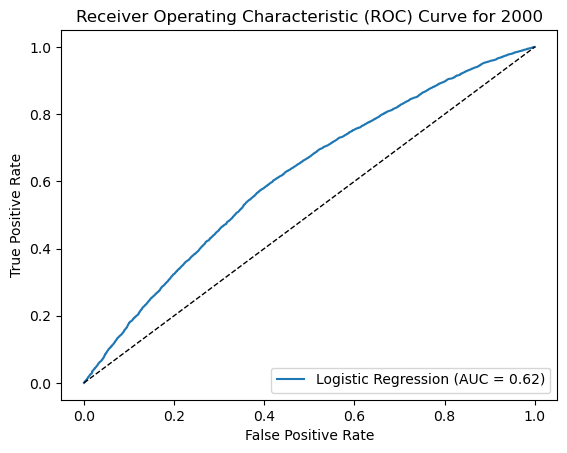

Coefficients for numerical features:
CRSDepTime: 0.04613339663764018
CRSArrTime: 0.13208794761087606
Distance: 0.29477113103640074
latitude: 0.15851671089094688
longitude: 0.19139121725153024


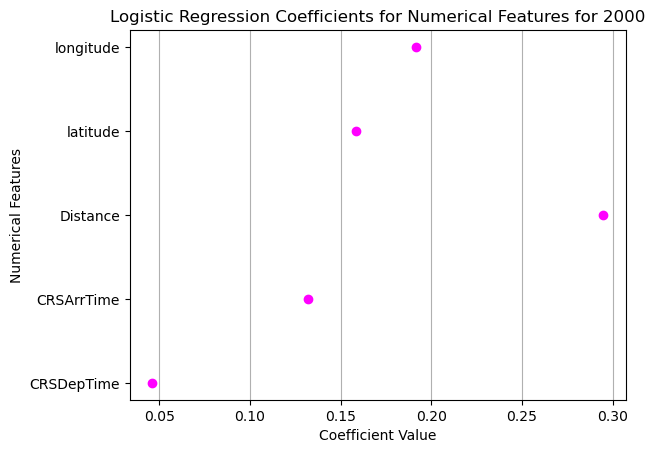

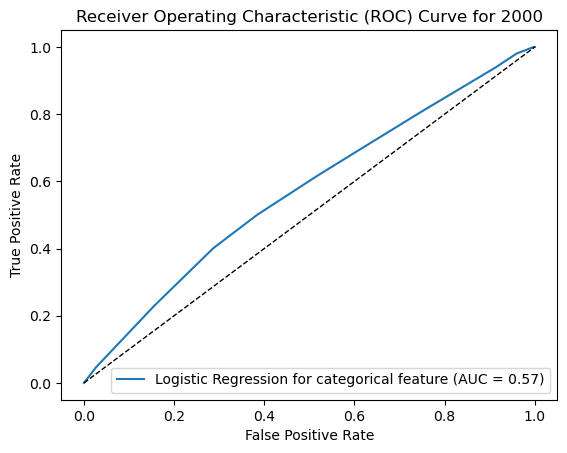

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.5856824644906768
UniqueCarrier_AQ: -1.8173086561849274
UniqueCarrier_AS: 0.6706494313985136
UniqueCarrier_CO: 0.07768904314856588
UniqueCarrier_DL: 0.03470341535495826
UniqueCarrier_HP: -0.4569959008385568
UniqueCarrier_NW: 0.2946691190902197
UniqueCarrier_TW: -0.042712160422939224
UniqueCarrier_UA: 0.15858125495415257
UniqueCarrier_US: 0.508859323534959
UniqueCarrier_WN: -0.0031346771847681663


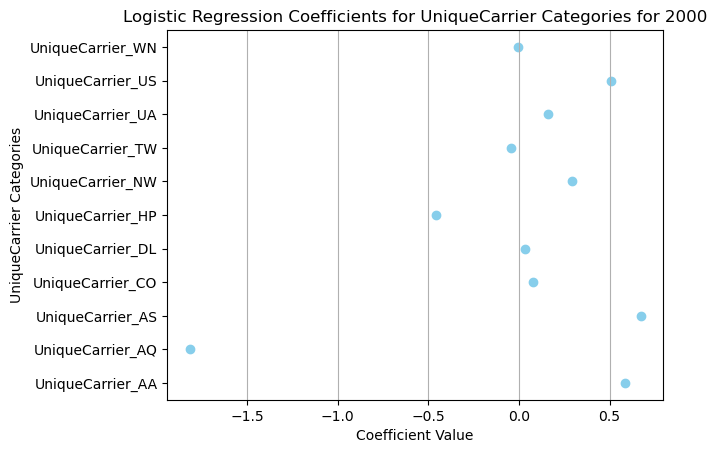

In [18]:
# Load the respective year dataset
df = pd.read_csv("2000.csv")

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2000')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2000')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2000')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2000')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.62 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.57 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself its generally not curved, almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has more limitations in distinguishing between positive and negative classes. Thus, categorical feature may be less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, the numerical features all have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that CRSDepTime has the lowest coefficient, meaning as CRSDepTime increases, the likelihood of the CRSDepTime feature to be in the positive class is lowest compared to the others

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class

#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_AQ has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_AS has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has more negative coefficients and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2001

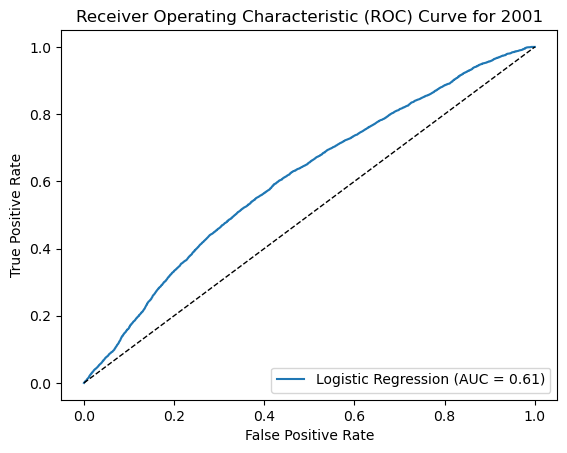

Coefficients for numerical features:
CRSDepTime: -0.07809578689342916
CRSArrTime: 0.10595832386648783
Distance: 0.315153246698238
latitude: 0.13069639929951438
longitude: 0.20791228271092657


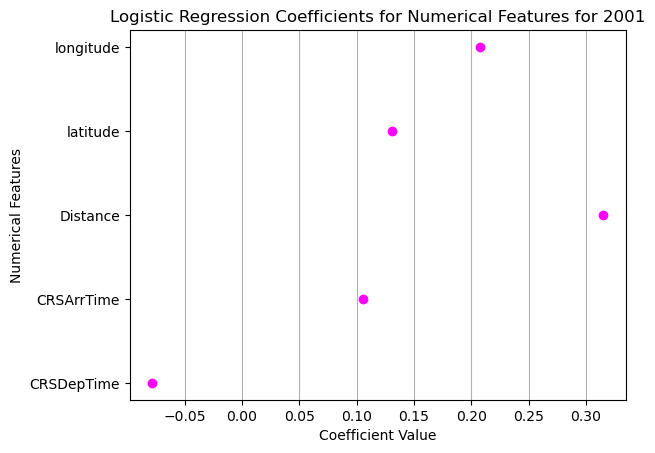

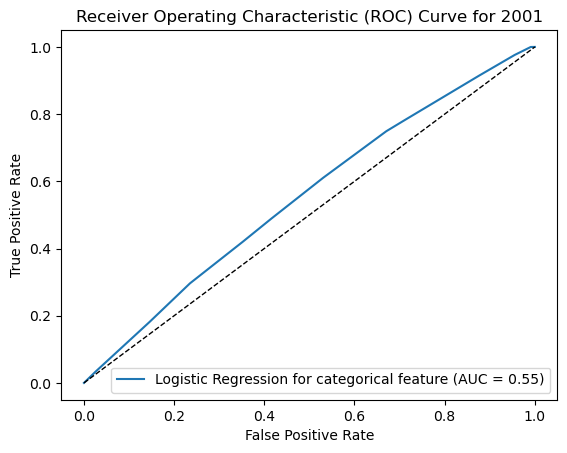

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.4756934401145897
UniqueCarrier_AQ: -2.7964068807438585
UniqueCarrier_AS: 0.6140107149837875
UniqueCarrier_CO: 0.35928512692734516
UniqueCarrier_DL: 0.2727031035495451
UniqueCarrier_HP: -0.16876654237038413
UniqueCarrier_MQ: -0.063372527637677
UniqueCarrier_NW: 0.4681679401996624
UniqueCarrier_TW: 0.08667981238785054
UniqueCarrier_UA: 0.38480344981900255
UniqueCarrier_US: 0.3309039438703747
UniqueCarrier_WN: 0.042068163427292055


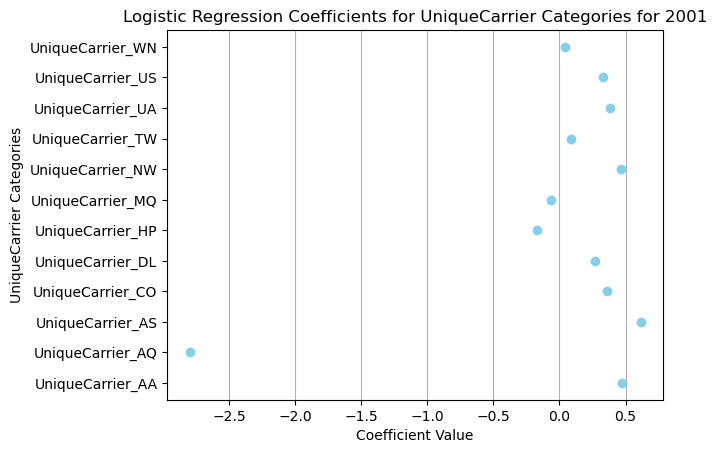

In [20]:
# Load the respective year dataset
df = pd.read_csv("2001.csv", encoding='iso-8859-1')

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")


# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2001')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2001')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2001')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2001')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.61 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.55 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_AQ has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_AS has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has a more negative value for its coefficient and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2002

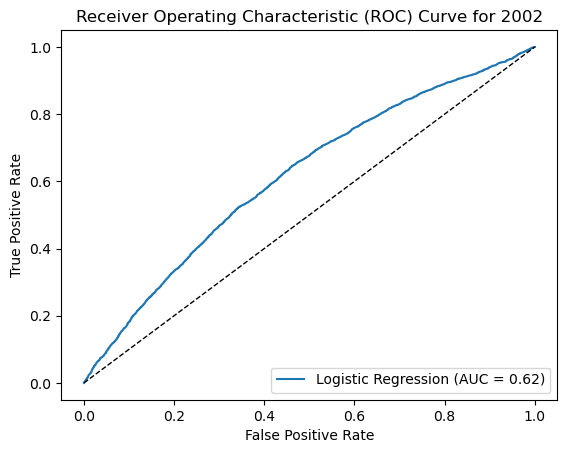

Coefficients for numerical features:
CRSDepTime: -0.05462799683228466
CRSArrTime: 0.20383369039076507
Distance: 0.2556761546679673
latitude: 0.18079778409936345
longitude: 0.03398098987429389


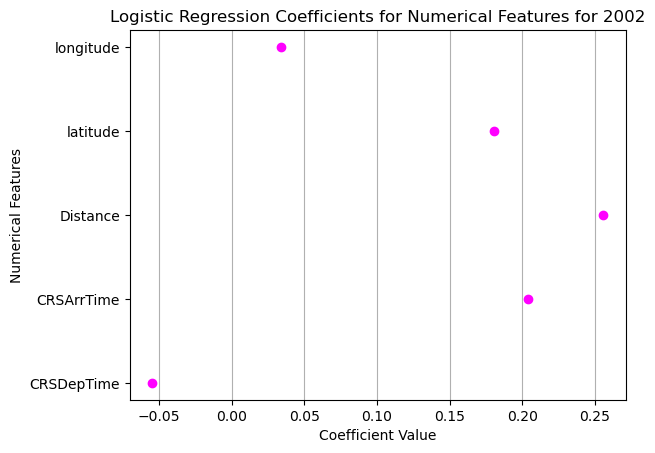

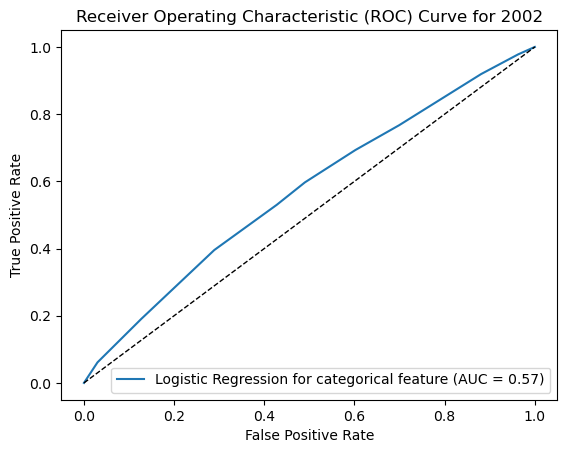

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.16361662674110788
UniqueCarrier_AS: 0.7907313061960533
UniqueCarrier_CO: -0.05841141755893728
UniqueCarrier_DL: -0.002051016946863385
UniqueCarrier_HP: -0.3584423752798708
UniqueCarrier_MQ: -0.3483436196679672
UniqueCarrier_NW: 0.20500944386337208
UniqueCarrier_UA: -0.09754867071064946
UniqueCarrier_US: -0.1390977709822476
UniqueCarrier_WN: -0.1550843429133252


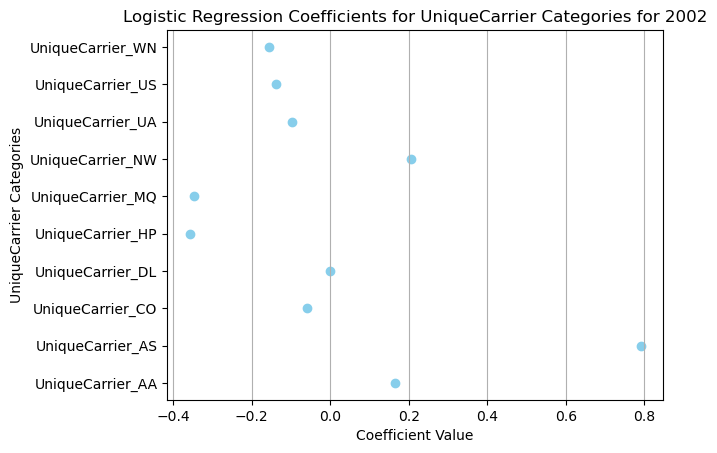

In [21]:
# Load the respective year dataset
df = pd.read_csv("2002.csv", encoding='iso-8859-1')

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

#  Changing the format to a year-month-day for datetime to work 
df['DepartureDate'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str), format='%Y-%m-%d')

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2002')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2002')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2002')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2002')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.62 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.57 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have an inverse relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the negative classes

#### We can see that UniqueCarrier_HP has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_AS has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has more negative coefficients, which explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2003

C:\Users\chongpl\AppData\Local\Temp\ipykernel_13896\4238785552.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("2003.csv.bz2")


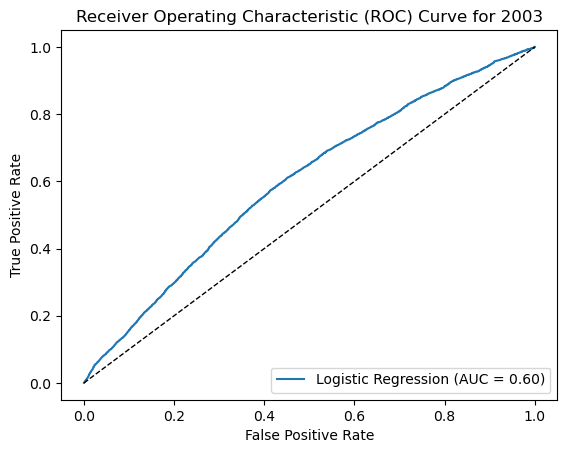

Coefficients for numerical features:
CRSDepTime: -0.04760208232644836
CRSArrTime: 0.07605521782150998
Distance: 0.2779171784780765
latitude: 0.08196126068995135
longitude: 0.09692594726120225


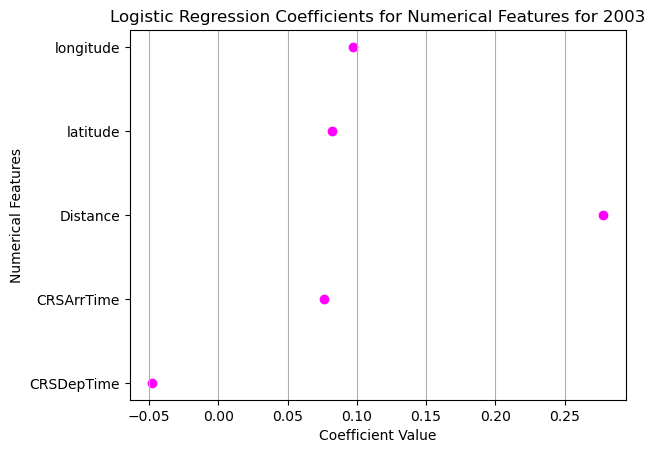

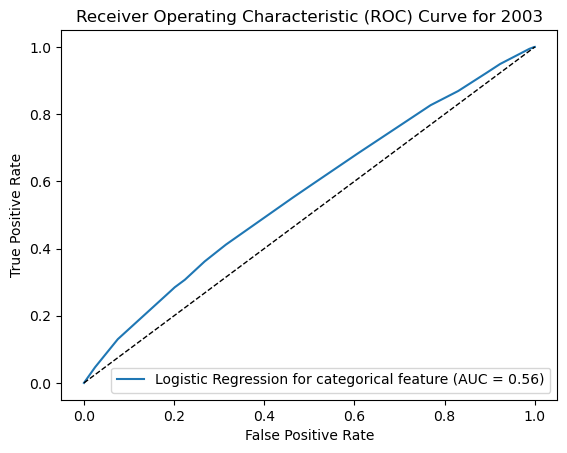

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.2782451364114929
UniqueCarrier_AS: 0.6424526917577561
UniqueCarrier_B6: 0.2595436245361016
UniqueCarrier_CO: 0.12863506368133934
UniqueCarrier_DH: 0.16719439399614713
UniqueCarrier_DL: 0.02741374782950903
UniqueCarrier_EV: 0.05905178218459575
UniqueCarrier_FL: 0.20541820751253648
UniqueCarrier_HA: -1.0866888784691433
UniqueCarrier_HP: -0.20138372919315198
UniqueCarrier_MQ: -0.23079571812047267
UniqueCarrier_NW: -0.04301096829387993
UniqueCarrier_OO: -0.05723994937169506
UniqueCarrier_TZ: -0.7548086175456248
UniqueCarrier_UA: -0.0003705378154921279
UniqueCarrier_US: -0.08970665032364303
UniqueCarrier_WN: 0.06877932026149734
UniqueCarrier_XE: 0.6273074544759399


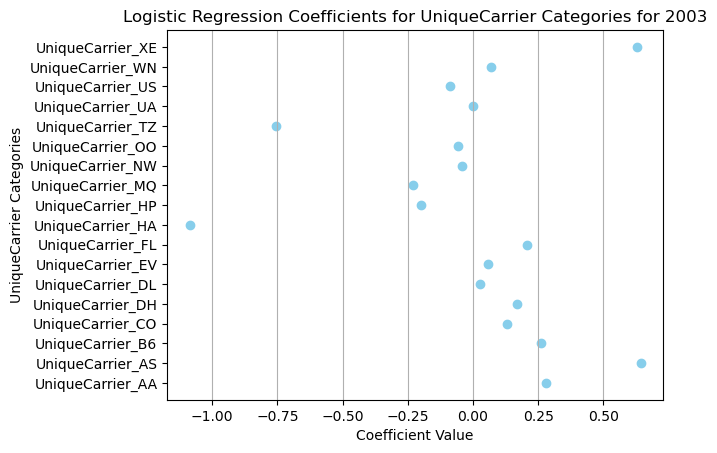

In [22]:
# Load the respective year dataset
df = pd.read_csv("2003.csv")

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

#  Changing the format to a year-month-day for datetime to work 
df['DepartureDate'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str), format='%Y-%m-%d')

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2003')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2003')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2003')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2003')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.60 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.56 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_HA has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_AS has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has a more negative value for its coefficient and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2004

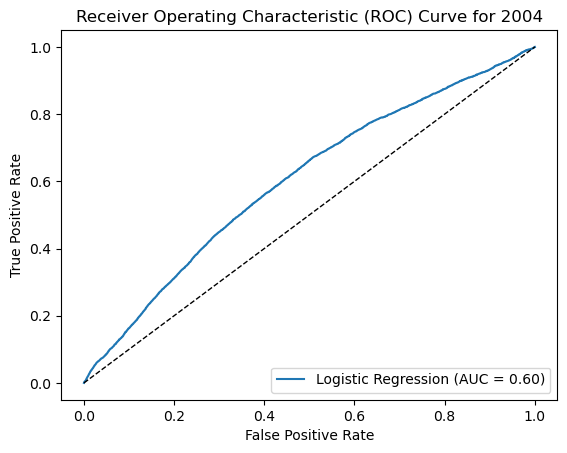

Coefficients for numerical features:
CRSDepTime: -0.11928027481040154
CRSArrTime: 0.22368674586535428
Distance: 0.26698022220348283
latitude: 0.05781286869982622
longitude: 0.07176206161180201


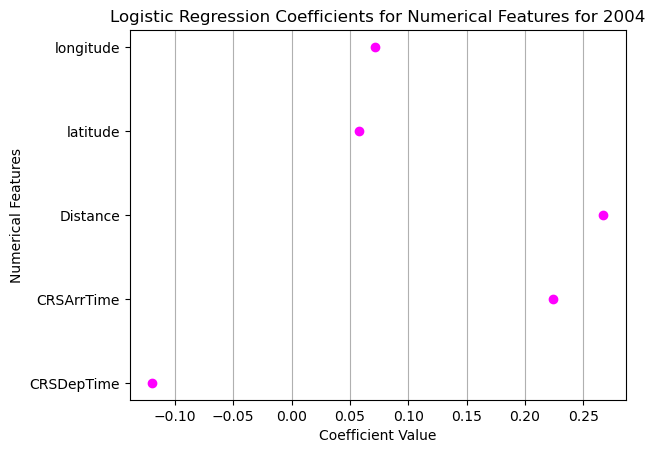

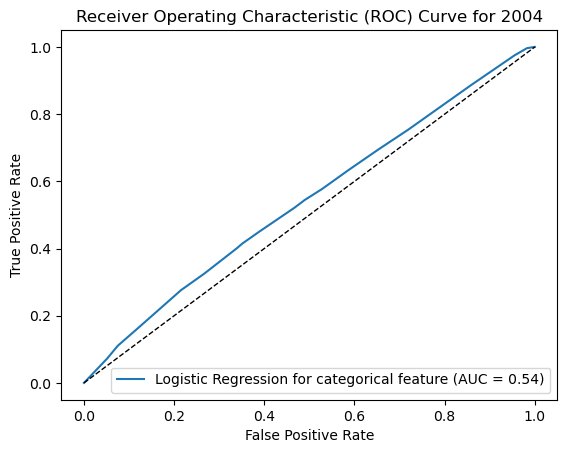

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.3877497428600871
UniqueCarrier_AS: 0.5524280377495749
UniqueCarrier_B6: 0.13331872979626827
UniqueCarrier_CO: 0.4697268085670749
UniqueCarrier_DH: 0.10589773248649173
UniqueCarrier_DL: 0.03208912840679859
UniqueCarrier_EV: 0.08670461486138069
UniqueCarrier_FL: 0.08998760730876933
UniqueCarrier_HA: -1.349242133820971
UniqueCarrier_HP: -0.11924882268747727
UniqueCarrier_MQ: 0.07711794412834548
UniqueCarrier_NW: 0.1462161566704532
UniqueCarrier_OH: 0.20658022429192327
UniqueCarrier_OO: 0.0546047091313554
UniqueCarrier_TZ: -1.6737567679805871
UniqueCarrier_UA: 0.09904709623919013
UniqueCarrier_US: 0.0790414047469093
UniqueCarrier_WN: 0.05211802731763326
UniqueCarrier_XE: 0.5606737899467137


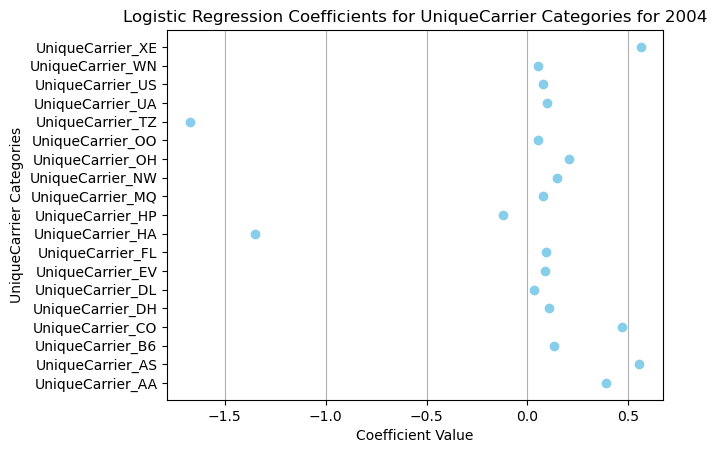

In [23]:
# Load the respective year dataset
df = pd.read_csv("2004.csv")

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

#  Changing the format to a year-month-day for datetime to work 
df['DepartureDate'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str), format='%Y-%m-%d')

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2004')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2004')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2004')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2004')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.60 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.54 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_TZ has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_XE has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has a more negative value for its coefficient and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2005

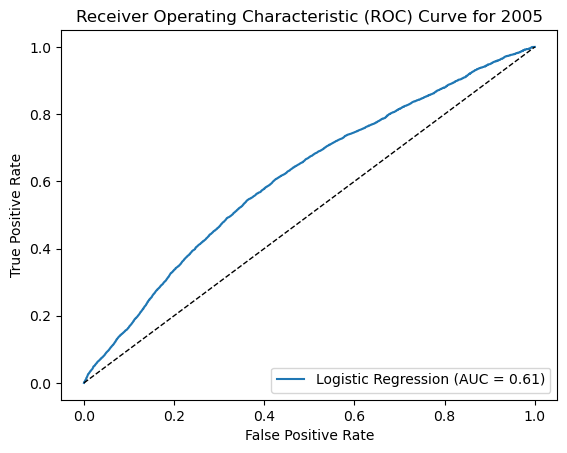

Coefficients for numerical features:
CRSDepTime: -0.13816084851937607
CRSArrTime: 0.19717419980728917
Distance: 0.2918459177802177
latitude: 0.08130170229269866
longitude: 0.1491290746955518


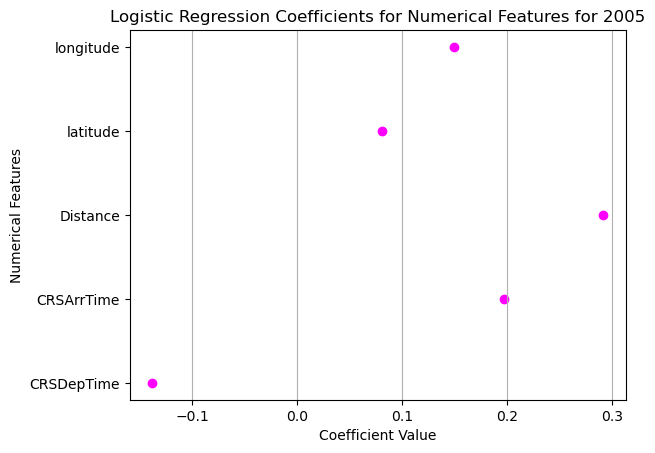

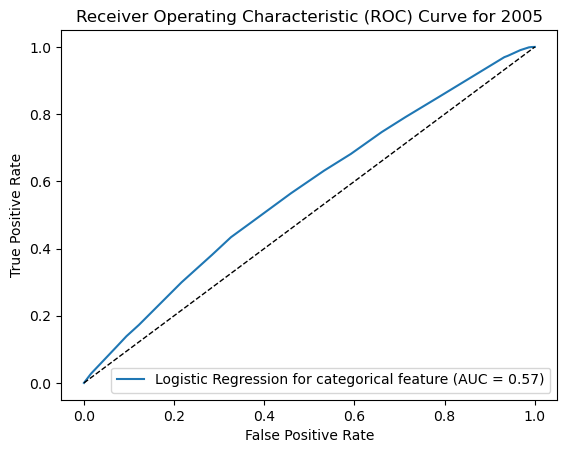

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.43839808332758595
UniqueCarrier_AS: 0.5894421525339911
UniqueCarrier_B6: 0.8868691642907247
UniqueCarrier_CO: 0.42204056936209383
UniqueCarrier_DH: -0.4110115817998926
UniqueCarrier_DL: 0.2335098184770946
UniqueCarrier_EV: 0.23672121716250163
UniqueCarrier_F9: -0.09364055958928892
UniqueCarrier_FL: 0.43906812708584203
UniqueCarrier_HA: -2.677290632719947
UniqueCarrier_HP: -0.2156402028891062
UniqueCarrier_MQ: 0.14228380382487954
UniqueCarrier_NW: 0.42246874794336226
UniqueCarrier_OH: 0.06511479758034204
UniqueCarrier_OO: -0.006426469981768263
UniqueCarrier_TZ: -1.3228008369767854
UniqueCarrier_UA: 0.08940705077261335
UniqueCarrier_US: 0.10283121007137455
UniqueCarrier_WN: -0.033271738237161924
UniqueCarrier_XE: 0.6025025273691119


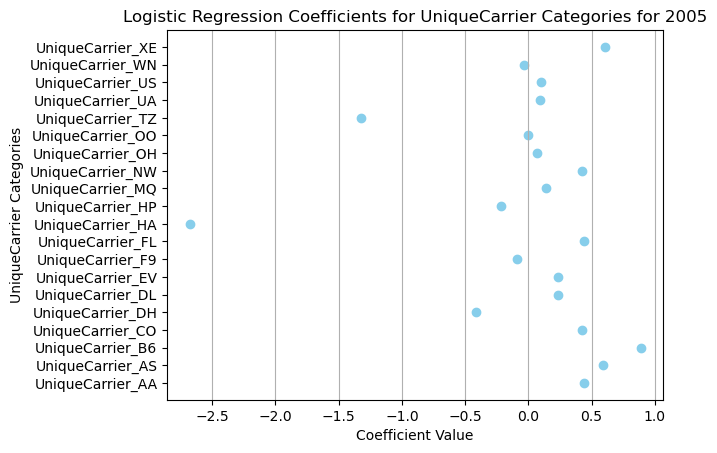

In [24]:
# Load the respective year dataset
df = pd.read_csv("2005.csv")

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

#  Changing the format to a year-month-day for datetime to work 
df['DepartureDate'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str), format='%Y-%m-%d')

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2005')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2005')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2005')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2005')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.61 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.57 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_HA has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_B6 has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has more negative coefficients and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2006

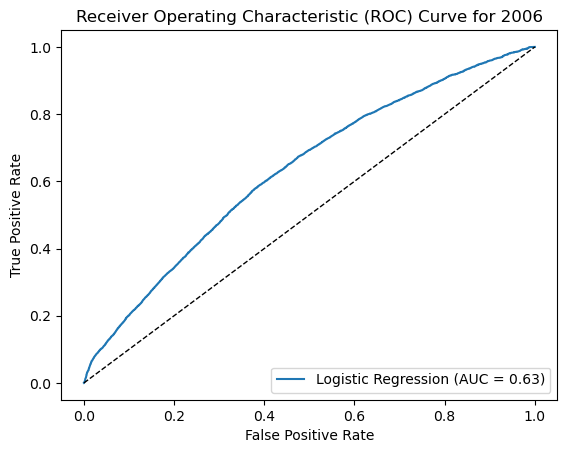

Coefficients for numerical features:
CRSDepTime: -0.111454786008357
CRSArrTime: 0.17083397000704148
Distance: 0.3587554110004028
latitude: 0.07322125017120941
longitude: 0.22012140112313175


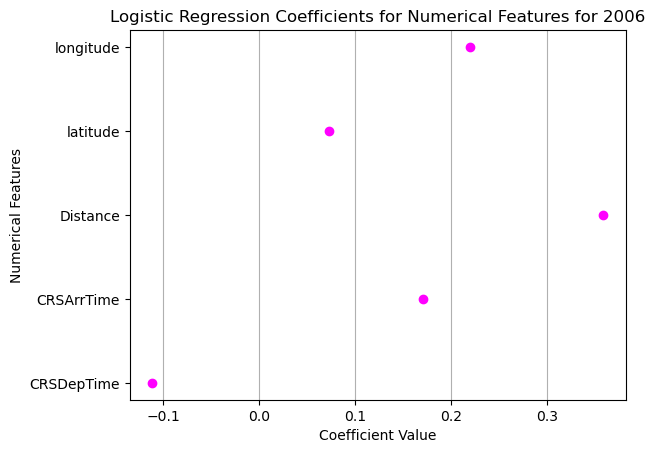

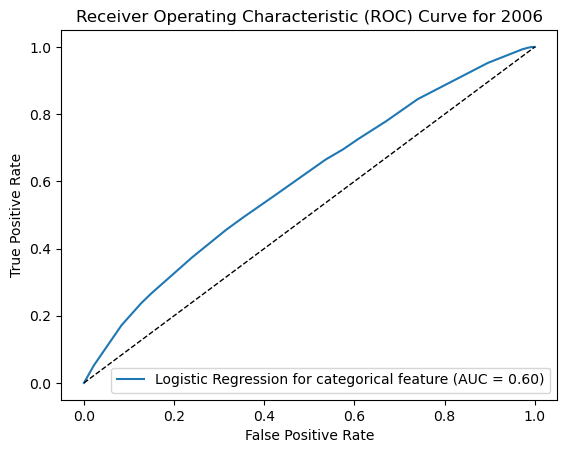

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.4198451626153929
UniqueCarrier_AQ: -1.6696574348666209
UniqueCarrier_AS: 0.6298575163857092
UniqueCarrier_B6: 1.0540431623432207
UniqueCarrier_CO: 0.6775758674144389
UniqueCarrier_DL: 0.2709840653389691
UniqueCarrier_EV: 0.19052425811622667
UniqueCarrier_F9: -0.5389739839606545
UniqueCarrier_FL: 0.1758202415073514
UniqueCarrier_HA: -1.8906795719481793
UniqueCarrier_MQ: 0.3190072592762799
UniqueCarrier_NW: 0.1619172344137547
UniqueCarrier_OH: 0.3177937975910259
UniqueCarrier_OO: -0.3940320058951832
UniqueCarrier_TZ: -1.1976235208496004
UniqueCarrier_UA: 0.278428158003526
UniqueCarrier_US: 0.10288194401863313
UniqueCarrier_WN: -0.0712713409367552
UniqueCarrier_XE: 0.9719077191262174
UniqueCarrier_YV: 0.23652779977273722


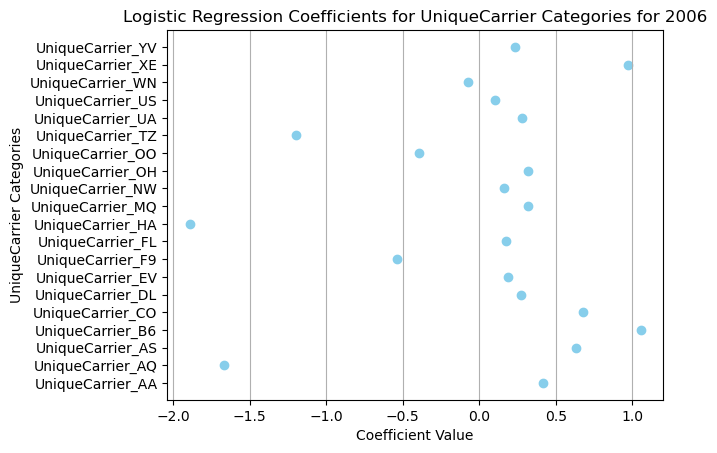

In [25]:
# Load the respective year dataset
df = pd.read_csv("2006.csv")

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

#  Changing the format to a year-month-day for datetime to work 
df['DepartureDate'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str), format='%Y-%m-%d')

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2006')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2006')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2006')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2006')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.63 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.60 shows that the predicitve model is better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is also gnenerally quite curved but almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC is lessed curved, hence it has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_HA has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_B6 has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has more negative coefficients and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2007

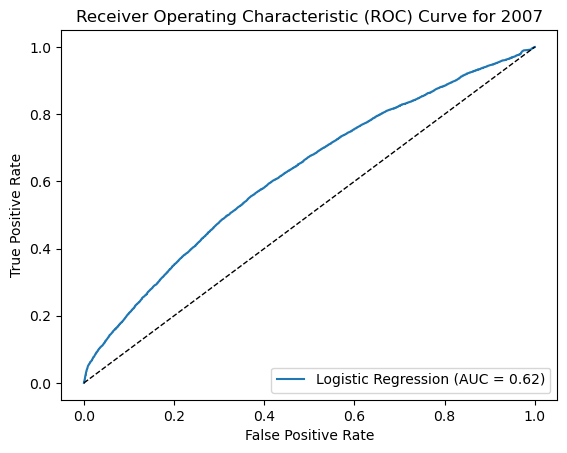

Coefficients for numerical features:
CRSDepTime: -0.3940054298110415
CRSArrTime: 0.45912095836975164
Distance: 0.2712588659337882
latitude: 0.05844793111108317
longitude: 0.17871643673665222


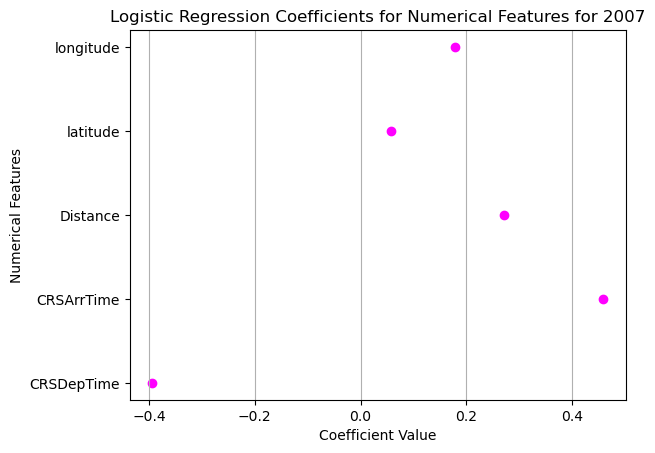

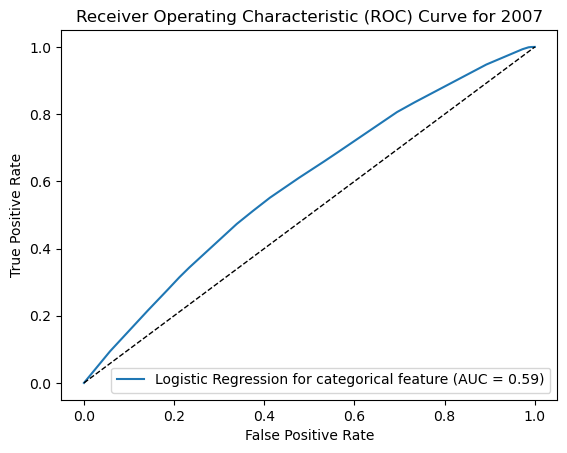

Coefficients for UniqueCarrier categories:
UniqueCarrier_9E: 0.44753277501830274
UniqueCarrier_AA: 0.6138175298067886
UniqueCarrier_AQ: -1.585260049937851
UniqueCarrier_AS: 0.5581394025389694
UniqueCarrier_B6: 0.577586042201594
UniqueCarrier_CO: 0.5913124506626316
UniqueCarrier_DL: 0.21745154110198495
UniqueCarrier_EV: 0.3313256241014106
UniqueCarrier_F9: -0.3110980198520999
UniqueCarrier_FL: 0.39556190959369
UniqueCarrier_HA: -2.8695377522105607
UniqueCarrier_MQ: 0.4479412719480491
UniqueCarrier_NW: 0.11496219408916611
UniqueCarrier_OH: 0.08826375592150193
UniqueCarrier_OO: -0.21441408496163966
UniqueCarrier_UA: 0.06480147419264519
UniqueCarrier_US: -0.06852061813523339
UniqueCarrier_WN: -0.112883343073771
UniqueCarrier_XE: 0.7866741228282261
UniqueCarrier_YV: -0.07550613316701682


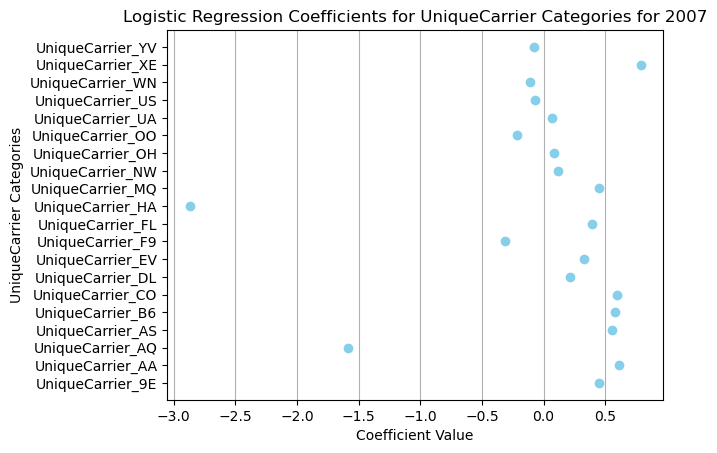

In [26]:
# Load the respective year dataset
df = pd.read_csv("2007.csv")

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

#  Changing the format to a year-month-day for datetime to work 
df['DepartureDate'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str), format='%Y-%m-%d')

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2007')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2007')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2007')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2007')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.62 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.59 shows that the predicitve model is better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is also generlaly quite curved but almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC is lessed curved and hence has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that CRSArrTime has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_HA has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_XE has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has more negative coefficients and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2008

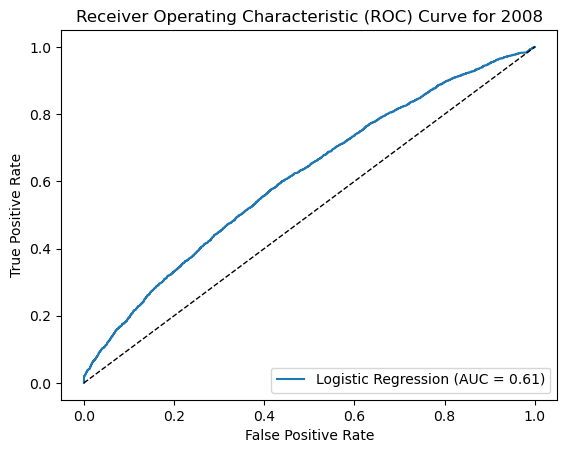

Coefficients for numerical features:
CRSDepTime: -0.5593192431785233
CRSArrTime: 0.4970877560946574
Distance: 0.19810785972088524
latitude: 0.10619640748338746
longitude: 0.13129142024710116


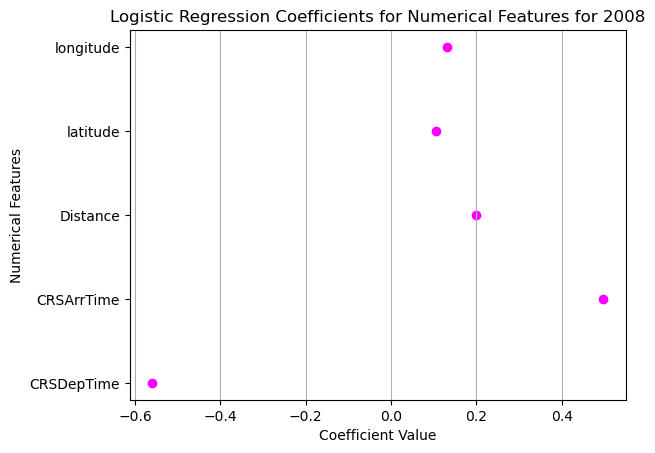

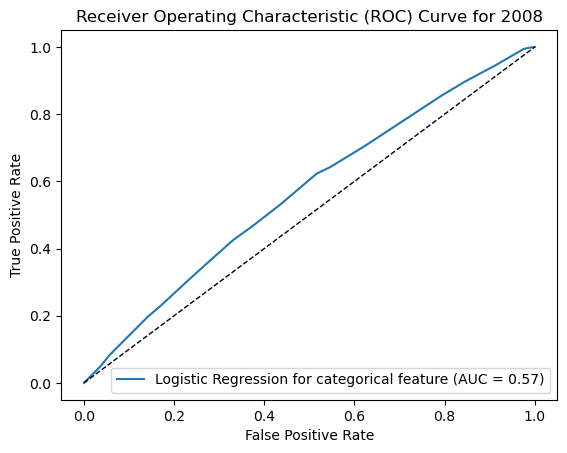

Coefficients for UniqueCarrier categories:
UniqueCarrier_9E: 0.4934874034090846
UniqueCarrier_AA: 0.3774179652901083
UniqueCarrier_AQ: -0.7921482475648463
UniqueCarrier_AS: 0.40864752180257147
UniqueCarrier_B6: 0.3519960324803251
UniqueCarrier_CO: 0.11885196186812656
UniqueCarrier_DL: 0.13893236705479098
UniqueCarrier_EV: 0.1498161319335031
UniqueCarrier_F9: -0.8626137560123118
UniqueCarrier_FL: 0.2694338632242399
UniqueCarrier_HA: -0.8939630268371191
UniqueCarrier_MQ: 0.31724502747376954
UniqueCarrier_NW: -0.15582553747603542
UniqueCarrier_OH: 0.132588427564672
UniqueCarrier_OO: 0.13753281589789165
UniqueCarrier_UA: -0.18149409581784653
UniqueCarrier_US: -0.33989769135074177
UniqueCarrier_WN: 0.015586729613116596
UniqueCarrier_XE: 0.2700703223048452
UniqueCarrier_YV: 0.06400605232347452


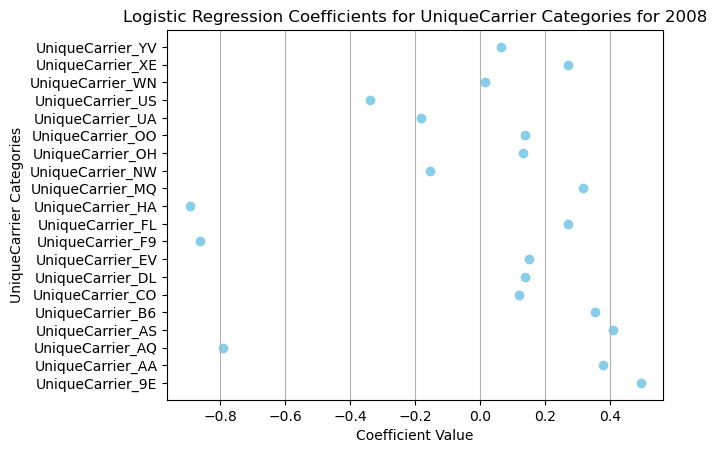

In [27]:
# Load the respective year dataset
df = pd.read_csv("2008.csv")

# Load the airports dataset
airports_df = pd.read_csv("airports.csv") 

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

#  Changing the format to a year-month-day for datetime to work 
df['DepartureDate'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str), format='%Y-%m-%d')

# Merging
merged_df = df.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

# Filtering 
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Calculating
merged_df['Midpoint_Latitude'] = (merged_df['lat_Destination'] + merged_df['lat_Arrival']) / 2
merged_df['Midpoint_Longitude'] = (merged_df['long_Destination'] + merged_df['long_Arrival']) / 2

# Coordinates feature breakdown 
merged_df['latitude'] = merged_df['Midpoint_Latitude']
merged_df['longitude'] = merged_df['Midpoint_Longitude']


#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2008')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2008')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df = merged_df[(merged_df['Cancelled'] == 0)]

# Classifying
feature = merged_df[['UniqueCarrier']]
X = feature
Y = merged_df['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2008')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2008')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.61 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.57 shows that the predicitve model is slightly better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes and there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that CRSArrTime has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_HA has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_9E has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has a more negative value for its coefficient and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

## Condensing 1st 5 years years of data into 1 dataframe

In [2]:
# Read 5 consecutive years of data

df99= pd.read_csv("1999.csv")
df00= pd.read_csv("2000.csv")
df01= pd.read_csv("2001.csv", encoding='iso-8859-1')
df02= pd.read_csv("2002.csv", encoding='iso-8859-1')
df03= pd.read_csv("2003.csv")

C:\Users\clare\AppData\Local\Temp\ipykernel_5220\4286119527.py:7: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df03= pd.read_csv("2003.csv.bz2")


In [3]:
# List of DataFrames with 5 years tgt 
dfs_total_1stpart = [
    df99,
    df00,
    df01,
    df02,
    df03
]

# Concatenate the DataFrames in the list along the rows axis
dfs_total_1stpart = pd.concat(dfs_total_1stpart, ignore_index=True)

In [4]:
# Load the airports dataset
airports_df = pd.read_csv("airports.csv")

# Load the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

In [6]:
# Merge airports_df and carriers_df into df
merged_df_1stpart = dfs_total_1stpart.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

In [7]:
# Filter out canceled flights i.e Cancelled == 1 
merged_df_1stpart = merged_df_1stpart[(merged_df_1stpart['Cancelled'] == 0)]

In [8]:
# Calculate the midpoint coordinates
merged_df_1stpart['Midpoint_Latitude'] = (merged_df_1stpart['lat_Destination'] + merged_df_1stpart['lat_Arrival']) / 2
merged_df_1stpart['Midpoint_Longitude'] = (merged_df_1stpart['long_Destination'] + merged_df_1stpart['long_Arrival']) / 2

# Coordinates feature would conisit of latitude and longitude separately to prevent value error in following codes 

merged_df_1stpart['latitude'] = merged_df_1stpart['Midpoint_Latitude']
merged_df_1stpart['longitude'] = merged_df_1stpart['Midpoint_Longitude']


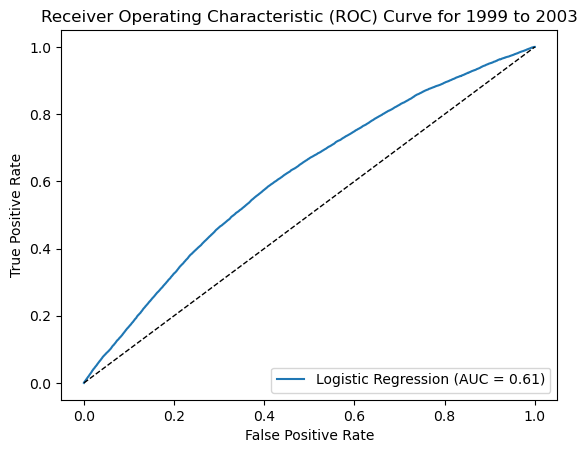

Coefficients for numerical features:
CRSDepTime: -0.03586843077534345
CRSArrTime: 0.11301230147704733
Distance: 0.30411967454612476
latitude: 0.14413980340074475
longitude: 0.15182638452138683


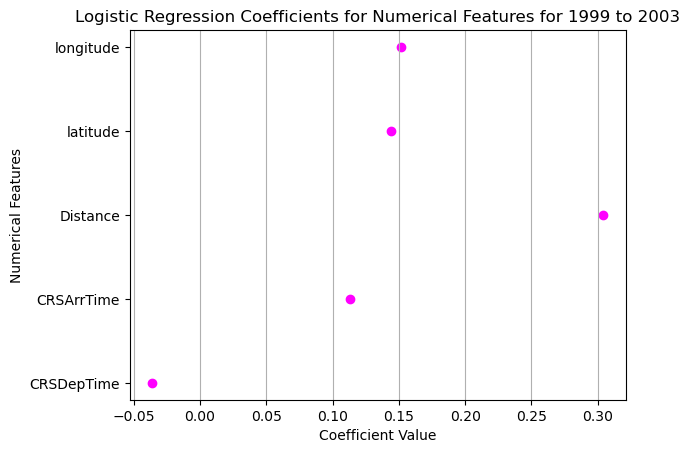

C:\Users\clare\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\clare\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

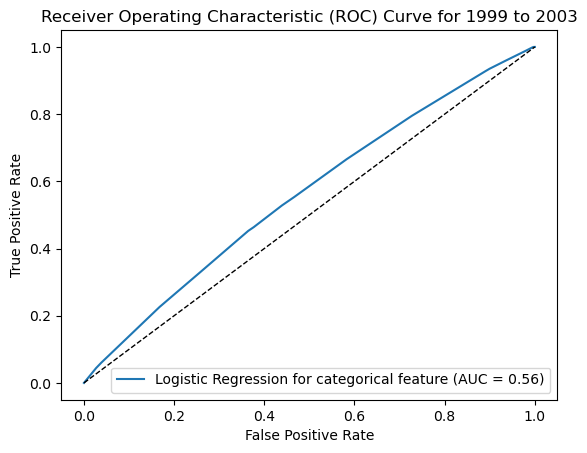

Coefficients for UniqueCarrier categories:
UniqueCarrier_AA: 0.3853510041540988
UniqueCarrier_AQ: -2.8509423173171027
UniqueCarrier_AS: 0.6389803118616213
UniqueCarrier_B6: 0.2101815174536831
UniqueCarrier_CO: 0.1459171912008302
UniqueCarrier_DH: 0.14626439577639277
UniqueCarrier_DL: 0.026989235608150496
UniqueCarrier_EV: -0.12297564067861749
UniqueCarrier_FL: -0.010061289898712134
UniqueCarrier_HA: -1.1147695347939288
UniqueCarrier_HP: -0.34946552277720266
UniqueCarrier_MQ: -0.35646147462653716
UniqueCarrier_NW: 0.29479411131513017
UniqueCarrier_OO: -0.38796699954739755
UniqueCarrier_TW: 0.1120828083361928
UniqueCarrier_TZ: -0.88039435479205
UniqueCarrier_UA: 0.0913773921032717
UniqueCarrier_US: 0.2851018844043234
UniqueCarrier_WN: -0.082699749226768
UniqueCarrier_XE: 0.46346567035535535


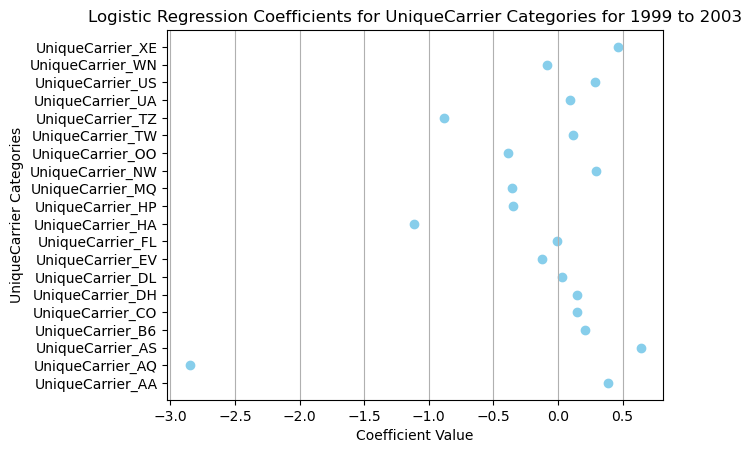

In [10]:
#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df_1stpart[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df_1stpart['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 1999 to 2003')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 1999 to 2003')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df_1stpart = merged_df_1stpart[(merged_df_1stpart['Cancelled'] == 0)]

# Classifying
feature = merged_df_1stpart[['UniqueCarrier']]
X = feature
Y = merged_df_1stpart['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 1999 to 2003')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 1999 to 2003')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.61 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes but there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.56 shows that the predicitve model is better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes but there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_AQ has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_AS has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has a more negative value for its coefficient and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 

### 2nd half of the 10 years

In [2]:
# Read the next 5 years of data 

df04= pd.read_csv("2004.csv")
df05= pd.read_csv("2005.csv")
df06= pd.read_csv("2006.csv")
df07= pd.read_csv("2007.csv")
df08= pd.read_csv("2008.csv")

In [3]:
# List of DataFrames with 5 years tgt 
dfs_total_2ndpart = [
    df04,
    df05,
    df06,
    df07,
    df08
]

# Concatenate the DataFrames in the list along the rows axis
dfs_total_2ndpart = pd.concat(dfs_total_2ndpart, ignore_index=True)

In [4]:
# Re read the airports dataset
airports_df = pd.read_csv("airports.csv")

# Re read the carriers dataset 
carriers_df = pd.read_csv("carriers.csv")

In [5]:
# Merge airports_df and carriers_df into df
merged_df_2ndpart = dfs_total_2ndpart.merge(airports_df, left_on='Origin', right_on='iata', how='left', suffixes=('_Departure', '_Origin')) \
              .merge(airports_df, left_on='Dest', right_on='iata', how='left', suffixes=('_Arrival', '_Destination')) \
              .merge(carriers_df, left_on='UniqueCarrier', right_on='Code', how='left')

In [6]:
# Filter out canceled flights i.e Cancelled == 1 
merged_df_2ndpart = merged_df_2ndpart[(merged_df_2ndpart['Cancelled'] == 0)]

In [7]:
# Calculate the midpoint coordinates
merged_df_2ndpart['Midpoint_Latitude'] = (merged_df_2ndpart['lat_Destination'] + merged_df_2ndpart['lat_Arrival']) / 2
merged_df_2ndpart['Midpoint_Longitude'] = (merged_df_2ndpart['long_Destination'] + merged_df_2ndpart['long_Arrival']) / 2

# Coordinates feature would conisit of latitude and longitude separately to prevent value error in following codes 

merged_df_2ndpart['latitude'] = merged_df_2ndpart['Midpoint_Latitude']
merged_df_2ndpart['longitude'] = merged_df_2ndpart['Midpoint_Longitude']

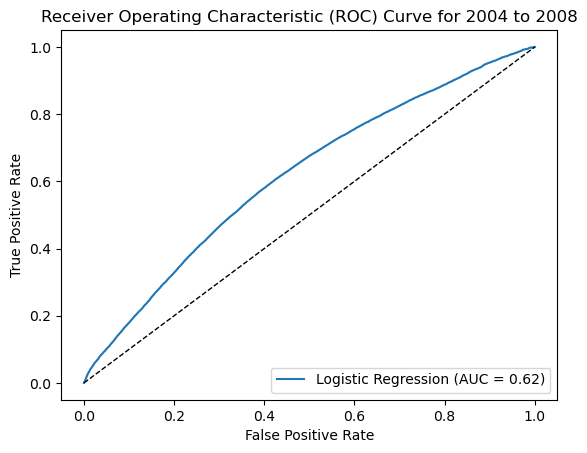

Coefficients for numerical features:
CRSDepTime: -0.17473118523533815
CRSArrTime: 0.237340010777417
Distance: 0.30803140447689714
latitude: 0.07149443332349396
longitude: 0.15301454527561562


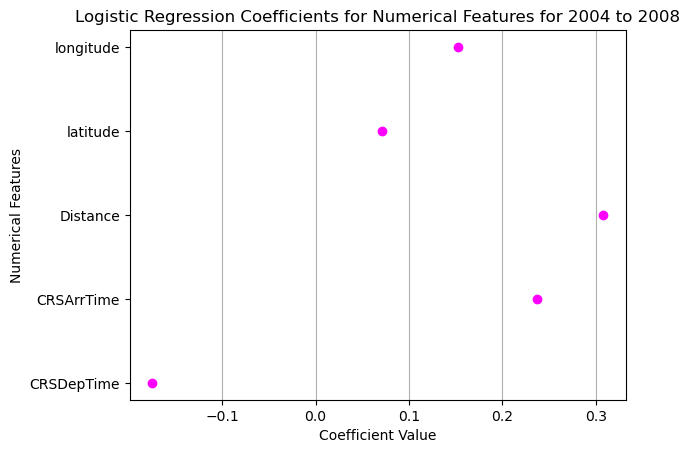

C:\Users\clare\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\clare\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

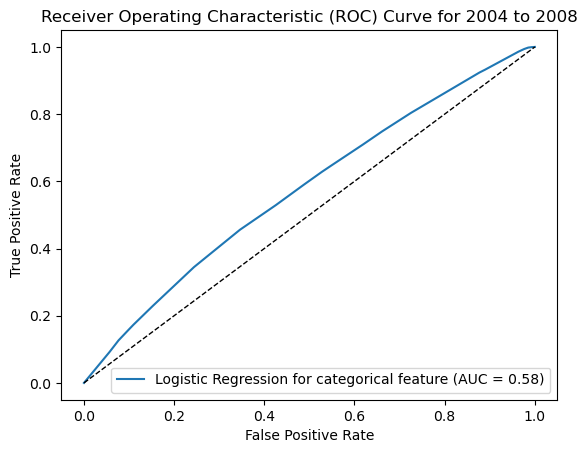

Coefficients for UniqueCarrier categories:
UniqueCarrier_9E: 0.5579689955729454
UniqueCarrier_AA: 0.493800843340378
UniqueCarrier_AQ: -1.2851382393967177
UniqueCarrier_AS: 0.5941452361767705
UniqueCarrier_B6: 0.7202964192702063
UniqueCarrier_CO: 0.5322983103667129
UniqueCarrier_DH: -0.06623601544410322
UniqueCarrier_DL: 0.20208400657404968
UniqueCarrier_EV: 0.19302434559981596
UniqueCarrier_F9: -0.4741213133758781
UniqueCarrier_FL: 0.30884778119416034
UniqueCarrier_HA: -2.202668535185738
UniqueCarrier_HP: -0.19283001558593366
UniqueCarrier_MQ: 0.27080287188453744
UniqueCarrier_NW: 0.19836281887406
UniqueCarrier_OH: 0.13562616378755848
UniqueCarrier_OO: -0.0913862131744446
UniqueCarrier_TZ: -1.5333329255822477
UniqueCarrier_UA: 0.14184178465150923
UniqueCarrier_US: 0.09195708648148275
UniqueCarrier_WN: -0.016687645313925012
UniqueCarrier_XE: 0.7244542386419687
UniqueCarrier_YV: 0.15584368017745998


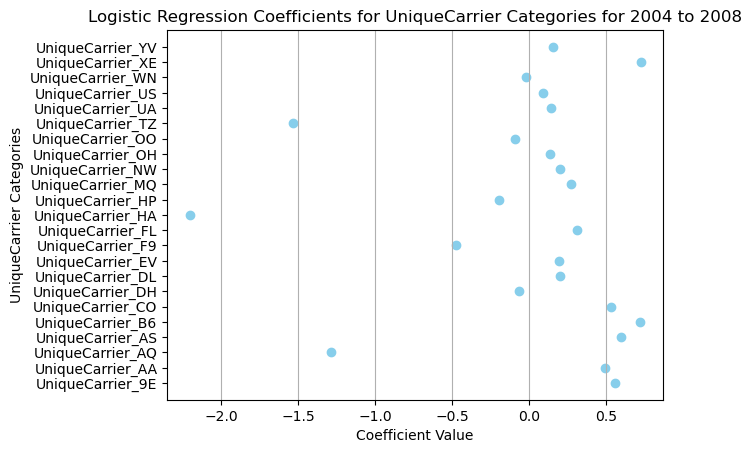

In [8]:
#### NUMERICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Classifying 
features = merged_df_2ndpart[['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']]
x = features  
y = merged_df_2ndpart['Diverted'].apply(lambda x: 1 if x == 1 else 0)
numerical_features = ['CRSDepTime', 'CRSArrTime', 'Distance', 'latitude', 'longitude']


# Machine learning pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(x_train, y_train)

# Plotting the logistic regression model
y_pred_prob = grid_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2004 to 2008')
plt.legend(loc='lower right')
plt.show()

# Getting & printing the coefficients
grid_lr.fit(x_train, y_train)

best_lr_model = grid_lr.best_estimator_['pipe_lr']

coefficients = best_lr_model.coef_[0]

numerical_feature_names = numerical_features

coefficients_map = dict(zip(numerical_feature_names, coefficients))

print("Coefficients for numerical features:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")


# Plotting the coefficients 
plt.scatter(coefficients, numerical_feature_names, color='magenta', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('Numerical Features')
plt.title('Logistic Regression Coefficients for Numerical Features for 2004 to 2008')
plt.grid(axis='x')
plt.show()

#### CATEGORICAL FEATURES LOGISTIC REGRESSION MODEL AND COEFFICIENTS ####

# Filtering
merged_df_2ndpart = merged_df_2ndpart[(merged_df_2ndpart['Cancelled'] == 0)]

# Classifying
feature = merged_df_2ndpart[['UniqueCarrier']]
X = feature
Y = merged_df_2ndpart['Diverted'].apply(lambda x: 1 if x == 1 else 0)
categorical_feature = ['UniqueCarrier']


# Machine learning pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', OneHotEncoder())])

data_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_feature)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

param_grid = {
    'data_transformer__categorical__imputer__strategy': ['most_frequent'],
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression())])


# Plotting the logistic regression model
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, Y_train)

Y_pred_prob = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

plt.plot(fpr, tpr, label='Logistic Regression for categorical feature (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 2004 to 2008')
plt.legend(loc='lower right')
plt.show()

# Finding & printing the coefficients
categories = grid_lr.best_estimator_['data_transformer'].named_transformers_['categorical'].named_steps['scaler'].get_feature_names_out(input_features=categorical_feature)

coefficients = grid_lr.best_estimator_['pipe_lr'].coef_[0]

coefficients_map = dict(zip(categories, coefficients))

print("Coefficients for UniqueCarrier categories:")
for category, coefficient in coefficients_map.items():
    print(f"{category}: {coefficient}")
 


# Plotting the coefficients

plt.scatter(coefficients, categories, color='skyblue', marker='o')
plt.xlabel('Coefficient Value')
plt.ylabel('UniqueCarrier Categories')
plt.title('Logistic Regression Coefficients for UniqueCarrier Categories for 2004 to 2008')
plt.grid(axis='x')
plt.show()

#### NUMERICAL VS CATEGORICAL ROC:
#### ___numerical__

#### AUC = 0.62 shows that the predicitve model is better than random guessing but it is still relatively ok in distinguishing between positive and negative classes 

#### The ROC curve itself its generally quite curved but it is almost a straight diagonal line, indicating that the predicitive model is limited at distinguishing between positive and negative classes and there's still room for improvement in the model
#### ___categorical__

#### AUC = 0.58 shows that the predicitve model is better than random guessing but it is relatively bad in distinguishing between positive and negative classes 

#### The ROC curve itself is almost a straight diagonal line, indicating that the predicitive model is very limited at distinguishing between positive and negative classes but there's still room for improvement in the model

#### In comparison to the numerical features ROC, the categorical feature ROC has much more limitations in distinguishing between positive and negative classes. Thus, categorical feature is less important in classification

#### NUMERICAL VS CATEGORICAL COEFFICIENT:
#### ___numerical__

#### From the diagram, most of the numerical features have a positive relationship with the predicting model where as when the values in the features increase, it is more likely for the features to be grouped into the positive classes

#### We can see that only CRSDepTime has a negative coefficient, meaning as CRSDepTime increases, its is more liekly for CRSDepTime feature to be in the negative class 

#### We can also see that Distance has the highest positive coefficient, meaning that when the distance increases, its is very likely to be in the positive class
#### ___categorical__

#### From the diagram, categorical feature generally have a positive relationship with the predicting model where as when the values in the features increase, it is likely for the features to be grouped into the positive classes

#### We can see that UniqueCarrier_HA has the most negative coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the negative class

#### We can see that UniqueCarrier_XE has the most positive coefficient, meaning as the number of flights via this carrier increases, it is very likely to be grouped into the positive class

#### Overall compared to numerical features, cateogrical feature has a more negative value for its coefficient and its positive coefficients are lower than numerical's, which also explains why cateogrical feature ROC Curve has a harder job in distinguishing between positive and negative classes 